1. Install Dependencies and Setup

In [81]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
import random
random.seed(42)

2. Remove dodgy images

In [82]:
data_dir = 'Data/2_classes_Brain_tumor' 

In [83]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']

In [84]:
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
#             # os.remove(image_path)

3. Load Data

In [85]:
data = tf.keras.utils.image_dataset_from_directory('Data/2_classes_Brain_tumor')

Found 2999 files belonging to 2 classes.


In [86]:
# tf.keras.preprocessing.image_dataset_from_directory(
#     directory,
#     labels='inferred',
#     label_mode='int',
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     pad_to_aspect_ratio=False,
#     data_format=None,
#     verbose=True
# )

In [87]:
print(len(data))

94


In [88]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001A3FEC3FF10>)

In [89]:
batch = data_iterator.next()
batch

(array([[[[  4.       ,   4.       ,   4.       ],
          [  4.       ,   4.       ,   4.       ],
          [  4.       ,   4.       ,   4.       ],
          ...,
          [  2.       ,   2.       ,   2.       ],
          [  2.       ,   2.       ,   2.       ],
          [  2.       ,   2.       ,   2.       ]],
 
         [[  4.       ,   4.       ,   4.       ],
          [  4.       ,   4.       ,   4.       ],
          [  4.       ,   4.       ,   4.       ],
          ...,
          [  2.6601562,   2.6601562,   2.6601562],
          [  2.6601562,   2.6601562,   2.6601562],
          [  2.6601562,   2.6601562,   2.6601562]],
 
         [[  4.       ,   4.       ,   4.       ],
          [  4.       ,   4.       ,   4.       ],
          [  4.       ,   4.       ,   4.       ],
          ...,
          [  3.       ,   3.       ,   3.       ],
          [  3.       ,   3.       ,   3.       ],
          [  3.       ,   3.       ,   3.       ]],
 
         ...,
 
         [[ 

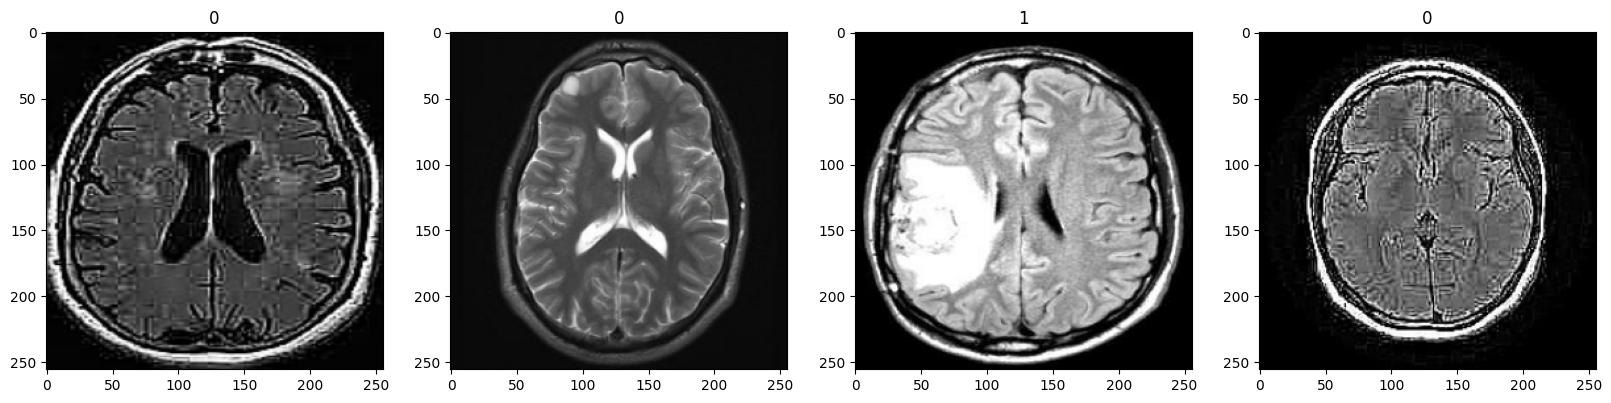

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [91]:
data = data.map(lambda x,y: (x/255, y))

In [92]:
data.as_numpy_iterator().next()

(array([[[[0.57926   , 0.57926   , 0.57926   ],
          [0.53657037, 0.53657037, 0.53657037],
          [0.55484354, 0.55484354, 0.55484354],
          ...,
          [0.5499373 , 0.5499373 , 0.5499373 ],
          [0.5277722 , 0.5277722 , 0.5277722 ],
          [0.57220817, 0.57220817, 0.57220817]],
 
         [[0.11220656, 0.11220656, 0.11220656],
          [0.00454915, 0.00454915, 0.00454915],
          [0.01627748, 0.01627748, 0.01627748],
          ...,
          [0.01998028, 0.01998028, 0.01998028],
          [0.00465591, 0.00465591, 0.00465591],
          [0.11088915, 0.11088915, 0.11088915]],
 
         [[0.11444307, 0.11444307, 0.11444307],
          [0.00165872, 0.00165872, 0.00165872],
          [0.01286047, 0.01286047, 0.01286047],
          ...,
          [0.01616929, 0.01616929, 0.01616929],
          [0.00380333, 0.00380333, 0.00380333],
          [0.11444307, 0.11444307, 0.11444307]],
 
         ...,
 
         [[0.12778799, 0.12778799, 0.12778799],
          [0.01580

5. Split Data

In [93]:
dataset = []
labels = []

INPUT_SIZE = (256,256)

label_mapping = {
    'no': 0, 
    'yes': 1
}

for image_class in os.listdir(data_dir): 
    class_index = label_mapping[image_class]
    class_path = os.path.join(data_dir, image_class)
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        if image_path.split('.')[-1] == 'jpg':
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, INPUT_SIZE)
            dataset.append(img)  
            labels.append(class_index)

dataset = np.array(dataset)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)
#test_size = 0.2: 20% của dữ liệu sẽ được chọn ngãu nhiên và sử dụng cho tập kiểm tra, 80% còn lại sẽ được sử dụng cho tập huấn luyện
#random_state = 0: Qúa trình ngẫu nhiên sẽ được khởi tạo với seed 0 -> muốn tái tạo kết quả hoặc so sánh kết quả giữa các phương pháp hoặc mô hình khác nhau.

In [94]:
# Reshape = (n, image_width, image_height, n_channel)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(2399, 256, 256, 3)
(2399,)
(600, 256, 256, 3)
(600,)


In [95]:
print(y_train)

[1 0 0 ... 1 1 1]


In [96]:
print(y_test)

[0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1
 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1
 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1
 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1
 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0
 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0
 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1
 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0
 1 1 1 0 1 0 1 1 0 1 1 0 

6. Build Deep Learning Model

In [97]:
model = Sequential()

In [98]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [99]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [100]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

7. Train

In [101]:
from keras.utils import to_categorical
from sklearn.preprocessing import normalize

In [102]:
logdir='logs'

In [103]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [104]:

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)


# Sau đó sử dụng callback trong quá trình fit
hist = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.6773 - loss: 20.6785 - val_accuracy: 0.8000 - val_loss: 0.4184
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8775 - loss: 0.3175 - val_accuracy: 0.9000 - val_loss: 0.2688
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.9579 - loss: 0.1294 - val_accuracy: 0.9283 - val_loss: 0.3162
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 0.9912 - loss: 0.0305 - val_accuracy: 0.9383 - val_loss: 0.2653
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.9976 - loss: 0.0104 - val_accuracy: 0.9483 - val_loss: 0.2832
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9483 - val_loss: 0.3776
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 329ms/step - accuracy: 1.0000 - loss: 4.5980e-04 - val_accuracy: 0.9467 - val_loss: 0.3857
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 1.0000 - loss: 2.6274e-04 -

8. Plot Performance

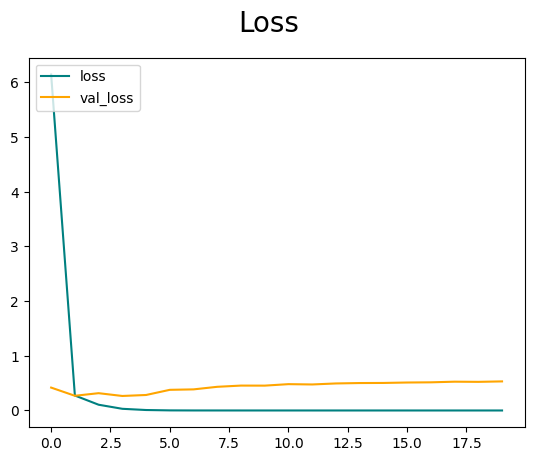

In [120]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

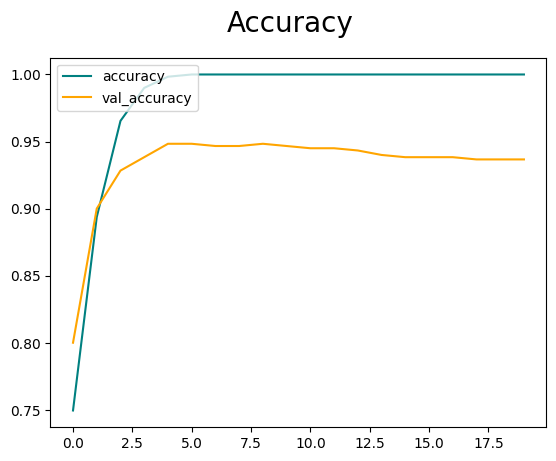

In [121]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [122]:
result=model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [123]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [124]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [110]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


10. Test

In [111]:
import cv2

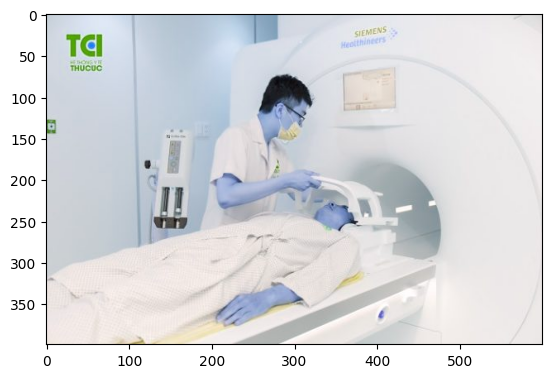

In [129]:
img = cv2.imread('Data/2_classes_Brain_tumor/chup-mri-co-anh-huong-den-suc-khoe-khong-1-600x399.jpg')
plt.imshow(img)
plt.show()

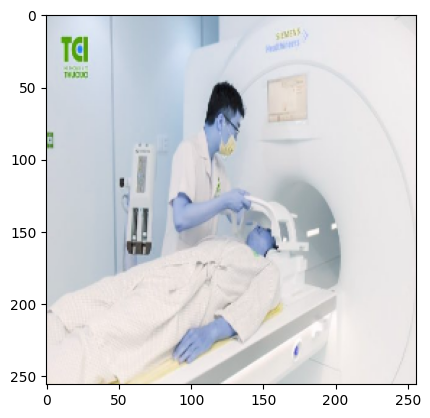

In [130]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [131]:
y_pred = model.predict(np.expand_dims(resize/256, 0))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


array([[0.4861658]], dtype=float32)

In [132]:
if y_pred > 0.5: 
    print(f'yes tumor')
else:
    print(f'no tumor')

no tumor


11. Save the Model

In [116]:
from tensorflow.keras.models import load_model

In [117]:
model.save(os.path.join('models','imageclassifier.h5'))

In [118]:
new_model = load_model('models/imageclassifier.h5')

In [119]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


array([[0.5717263]], dtype=float32)